In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def vec2(x,y):
    """
    Helper function for quickly creating 2D vectors without having to write too much text.
    """
    return np.array([x,y], dtype=np.float64)

class SimpleGrid2D:
    
    def __init__(self, min_coord, max_coord, I, J):
        if np.any(min_coord > max_coord):
            raise ValueError()
        if I < 2:
            raise ValueError()
        if J < 2:
            raise ValueError()

        self.min_coord = min_coord
        self.max_coord = max_coord
        
        self.I = I  # Number of nodes along x axis
        self.J = J  # Number of nodes along y axis
        
        res = np.array([I-1, J-1], dtype=np.float64)
        dims = (self.max_coord - self.min_coord)
        self.spacing = np.divide( dims, res)
        
        self.dx = self.spacing[0]
        self.dy = self.spacing[1]

        self.x = np.linspace(min_coord[0], max_coord[0], I)
        self.y = np.linspace(min_coord[1], max_coord[1], J)
    
        X, Y = np.meshgrid(self.x, self.y)
        self.X = X.T
        self.Y = Y.T
        self.values = np.zeros((I, J),dtype=np.float64)
        
    def interpolate(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(int(idx[0]), 0, self.I-2)
        j = np.clip(int(idx[1]), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0
    
    def eval_func(self, func):
        for i in range(self.I):
            for j in range(self.J):
                x = self.X[i,j]
                y = self.Y[i,j]
                self.values[i,j] = func(vec2(x,y))

In [3]:
def make_copy(grid):
    cpy = SimpleGrid2D(grid.min_coord, grid.max_coord, grid.I, grid.J)
    cpy.values = np.copy(grid.values)
    return cpy

def show_grid(grid, xlim=None, ylim=None, filename=None, error = None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(grid.values)
    ax.set_aspect('equal')
    if error is not None:
        ax.set_title(f'error: {error:.2e}')
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.colorbar(orientation='vertical')
    if filename is not None:
        fig.savefig(filename, dpi = 300)
    plt.show()

def show_grid_3d(grid, xlim=None, ylim=None, zlim=None, filename=None, error = None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(grid.X, grid.Y, grid.values,
                    cmap="magma",
                    color='0.75',
                    rstride=1,
                    cstride=1,
                    antialiased=False)
    ax.set_aspect('auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if error is not None:
        ax.set_title(f'error: {error:.2e}')
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if zlim is not None:
        ax.set_zlim(zlim)
    if filename is not None:
        fig.savefig(filename, dpi = 300)
    plt.show()
    
def peaks(p):
    x = p[0]
    y = p[1]    
    z = 3*((1-x)**2)*np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2 - y**2) - 1/3*np.exp(-(x+1)**2 - y**2)
    return z

def ramp(p):
    return p[0]

In [4]:
from time import sleep
from IPython import display

def step_advection(grid, u, dt):
    cpy = make_copy(grid)
    for i in range(cpy.I):
        for j in range(cpy.J):
            x = cpy.X[i,j]
            y = cpy.Y[i,j]
            
            ## Time integration
            k = 0                    
            x_old = vec2(x, y) - dt*u(x, y)
            φ_old = cpy.interpolate(x_old)
            cpy.values[i,j] = φ_old + dt*k
    grid = cpy
    return grid
        

def run_model(grid, u, dt, animate = False, zlim=None):
    ## Setting up problem to solve 
    T_init = 2.0*np.pi
    T = T_init
    print(f"Running on grid (I,J) = ({grid.I}, {grid.J}), total time = {T:.3f}, and timestep dt = {dt:.3f}")
    merit_0 = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy
    
    # Looping over time and solving iteratively'
    while T>0:
        grid = step_advection(grid, u, dt)
        T = T - dt
        if animate:
            show_grid_3d(grid, zlim=zlim)
            sleep(0)
            display.clear_output(wait=True)
        else:
            pDone = min(100, 100*(1-T/T_init))
            print(f"{pDone:.0f}% Done  ",end="\r")
        
    merit_T = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy
    error = np.abs(merit_T - merit_0) / np.abs(merit_0)
    return grid, error

In [5]:
doExp1 = False
doExp2 = True
doExp3 = False

In [6]:
if doExp1:
    def u1(x,y): return vec2(y, -x)
    Is = [32, 64, 128]
    dts = [0.02, 0.01, 0.005]
    min_coord = vec2(-5, -5)
    max_coord = vec2(5, 5)
    zlim=(-5,5)
    errors = np.zeros((len(Is), len(dts)))
    for i, I in enumerate(Is[::-1]):
        J = I
        for j, dt in enumerate(dts[::-1]):
            grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
            grid_init.eval_func(peaks)
            grid, error = run_model(grid_init, u1, dt)
            print(f"Error: {error:.3e}")
            errors[i,j] = max(error, 1)
            filename = f"advection_images/exp1_I_{I}_dt_{dt:.3f}_fin.png"
            show_grid_3d(grid, zlim=zlim, filename=filename, error=error)
            plt.close()

Text(0.5, 0, 'error')

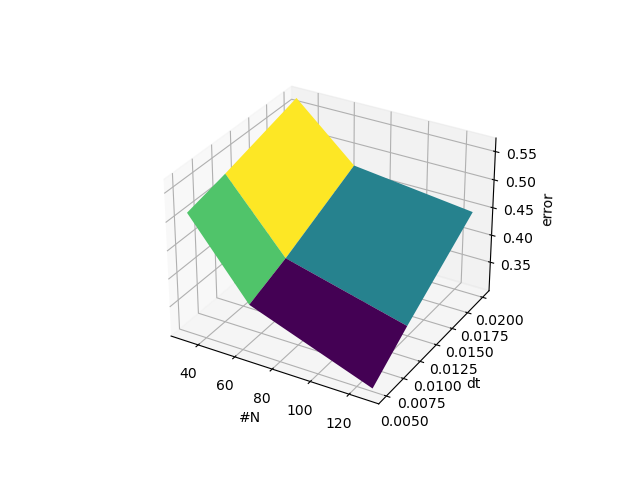

In [7]:
Is = np.array([32, 64, 128])
dts = np.array([0.02, 0.01, 0.005])
DI, DT = np.meshgrid(Is, dts)
errors = np.array([[0.568, 0.473, 0.447], [0.529, 0.409, 0.353], [0.512, 0.382, 0.302]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(DI, DT, errors, cmap="viridis", color='0.75', rstride=1, cstride=1)
ax.set_xlabel("#N")
ax.set_ylabel("dt")
ax.set_zlabel("error")
# fig.savefig("advection_images/exp1_errors.png", dpi = 300)


In [12]:
print(np.min(errors), np.max(errors))

0.302 0.568


Running on grid (I,J) = (128, 128), total time = 6.283, and timestep dt = 0.010
Error: 3.529e-01


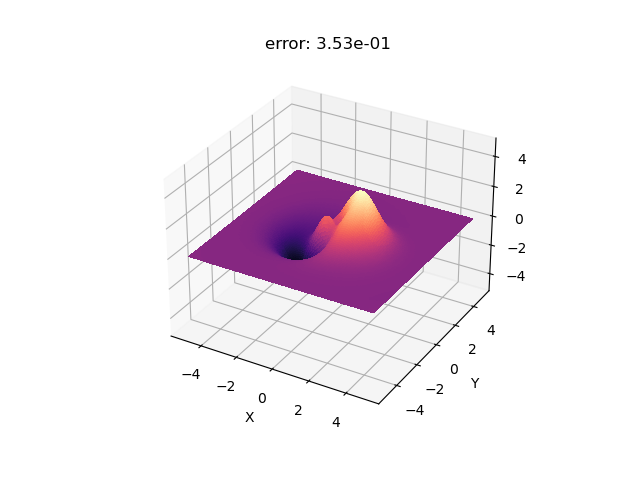

Running on grid (I,J) = (128, 128), total time = 6.283, and timestep dt = 0.010
Error: 3.529e-01


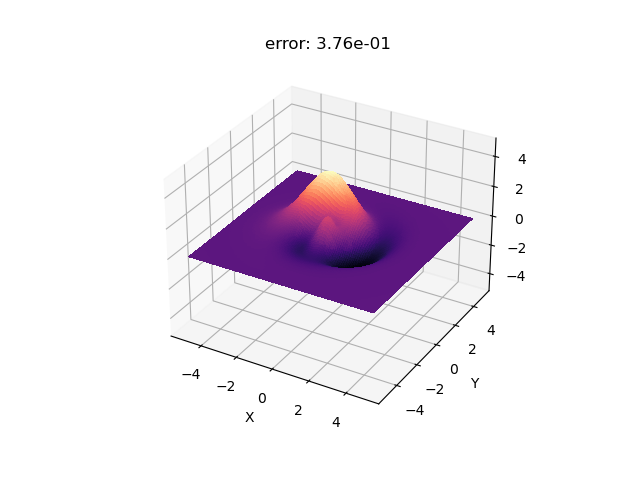

In [11]:
if doExp2:
    def u1(x,y): return vec2(y, -x)
    def u2(x, y): return vec2(-y, x)
    
    I = 128; J = I; dt = 0.01

    min_coord = vec2(-5, -5)
    max_coord = vec2(5, 5)

    grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
    grid_init.eval_func(peaks)
    zlim=(-5,5)
    
    
    grid1, error1 = run_model(grid_init, u1, dt)
    print(f"Error: {error1:.3e}")
    filename = f"advection_images/exp2_u1.png"
    show_grid_3d(grid1, zlim=zlim, filename=filename, error=error1)
    
    grid2, error2 = run_model(grid_init, u2, dt)
    print(f"Error: {error1:.3e}")
    filename = f"advection_images/exp2_u2.png"
    show_grid_3d(grid2, zlim=zlim, filename=filename, error=error2)
    
    plt.close()